In [1]:
import mxnet as mx

In [2]:
a = mx.nd.ones((2, 3), mx.gpu())

In [3]:
b = a * 2 + 1

In [4]:
b.asnumpy()

array([[3., 3., 3.],
       [3., 3., 3.]], dtype=float32)

In [5]:
import mxnet as mx

# Fixing the random seed
mx.random.seed(42)

mnist = mx.test_utils.get_mnist()

In [6]:
batch_size = 100
train_data = mx.io.NDArrayIter(mnist['train_data'], mnist['train_label'], batch_size, shuffle=True)
val_data = mx.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)

In [7]:
from __future__ import print_function
import mxnet as mx
from mxnet import gluon
from mxnet.gluon import nn
from mxnet import autograd as ag

In [8]:
net = nn.Sequential()
with net.name_scope():
    net.add(nn.Dense(128, activation='relu'))
    net.add(nn.Dense(64, activation='relu'))
    net.add(nn.Dense(10))

In [13]:
gpus = mx.test_utils.list_gpus()
ctx =  [mx.gpu()] if gpus else [mx.cpu(0), mx.cpu(1)]
net.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.02})

In [14]:
%%time
epoch = 10
# Use Accuracy as the evaluation metric.
metric = mx.metric.Accuracy()
softmax_cross_entropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()
for i in range(epoch):
    # Reset the train data iterator.
    train_data.reset()
    # Loop over the train data iterator.
    for batch in train_data:
        # Splits train data into multiple slices along batch_axis
        # and copy each slice into a context.
        data = gluon.utils.split_and_load(batch.data[0], ctx_list=ctx, batch_axis=0)
        # Splits train labels into multiple slices along batch_axis
        # and copy each slice into a context.
        label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
        outputs = []
        # Inside training scope
        with ag.record():
            for x, y in zip(data, label):
                z = net(x)
                # Computes softmax cross entropy loss.
                loss = softmax_cross_entropy_loss(z, y)
                # Backpropagate the error for one iteration.
                loss.backward()
                outputs.append(z)
        # Updates internal evaluation
        metric.update(label, outputs)
        # Make one step of parameter update. Trainer needs to know the
        # batch size of data to normalize the gradient by 1/batch_size.
        trainer.step(batch.data[0].shape[0])
    # Gets the evaluation result.
    name, acc = metric.get()
    # Reset evaluation result to initial state.
    metric.reset()
    print('training acc at epoch %d: %s=%f'%(i, name, acc))

training acc at epoch 0: accuracy=0.976950
training acc at epoch 1: accuracy=0.979100
training acc at epoch 2: accuracy=0.980267
training acc at epoch 3: accuracy=0.981283
training acc at epoch 4: accuracy=0.982217
training acc at epoch 5: accuracy=0.982933
training acc at epoch 6: accuracy=0.983167
training acc at epoch 7: accuracy=0.983617
training acc at epoch 8: accuracy=0.984067
training acc at epoch 9: accuracy=0.984517
Wall time: 12.5 s


In [15]:
metric = mx.metric.Accuracy()
# Reset the validation data iterator.
val_data.reset()
# Loop over the validation data iterator.
for batch in val_data:
    # Splits validation data into multiple slices along batch_axis
    # and copy each slice into a context.
    data = gluon.utils.split_and_load(batch.data[0], ctx_list=ctx, batch_axis=0)
    # Splits validation label into multiple slices along batch_axis
    # and copy each slice into a context.
    label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
    outputs = []
    for x in data:
        outputs.append(net(x))
    # Updates internal evaluation
    metric.update(label, outputs)
print('validation acc: %s=%f'%metric.get())
assert metric.get()[1] > 0.94

validation acc: accuracy=0.970400


In [16]:
import mxnet.ndarray as F

class Net(gluon.Block):
    def __init__(self, **kwargs):
        super(Net, self).__init__(**kwargs)
        with self.name_scope():
            # layers created in name_scope will inherit name space
            # from parent layer.
            self.conv1 = nn.Conv2D(20, kernel_size=(5,5))
            self.pool1 = nn.MaxPool2D(pool_size=(2,2), strides = (2,2))
            self.conv2 = nn.Conv2D(50, kernel_size=(5,5))
            self.pool2 = nn.MaxPool2D(pool_size=(2,2), strides = (2,2))
            self.fc1 = nn.Dense(500)
            self.fc2 = nn.Dense(10)

    def forward(self, x):
        x = self.pool1(F.tanh(self.conv1(x)))
        x = self.pool2(F.tanh(self.conv2(x)))
        # 0 means copy over size from corresponding dimension.
        # -1 means infer size from the rest of dimensions.
        x = x.reshape((0, -1))
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x

In [17]:
net = Net()

In [18]:
ctx = [mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()]
net.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.03})

In [19]:
metric = mx.metric.Accuracy()
softmax_cross_entropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()

for i in range(epoch):
    # Reset the train data iterator.
    train_data.reset()
    # Loop over the train data iterator.
    for batch in train_data:
        # Splits train data into multiple slices along batch_axis
        # and copy each slice into a context.
        data = gluon.utils.split_and_load(batch.data[0], ctx_list=ctx, batch_axis=0)
        # Splits train labels into multiple slices along batch_axis
        # and copy each slice into a context.
        label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
        outputs = []
        # Inside training scope
        with ag.record():
            for x, y in zip(data, label):
                z = net(x)
                # Computes softmax cross entropy loss.
                loss = softmax_cross_entropy_loss(z, y)
                # Backpropogate the error for one iteration.
                loss.backward()
                outputs.append(z)
        # Updates internal evaluation
        metric.update(label, outputs)
        # Make one step of parameter update. Trainer needs to know the
        # batch size of data to normalize the gradient by 1/batch_size.
        trainer.step(batch.data[0].shape[0])
    # Gets the evaluation result.
    name, acc = metric.get()
    # Reset evaluation result to initial state.
    metric.reset()
    print('training acc at epoch %d: %s=%f'%(i, name, acc))

training acc at epoch 0: accuracy=0.859800
training acc at epoch 1: accuracy=0.937317
training acc at epoch 2: accuracy=0.953217
training acc at epoch 3: accuracy=0.961850
training acc at epoch 4: accuracy=0.967800
training acc at epoch 5: accuracy=0.971633
training acc at epoch 6: accuracy=0.974467
training acc at epoch 7: accuracy=0.976783
training acc at epoch 8: accuracy=0.978200
training acc at epoch 9: accuracy=0.979933


In [20]:
# Use Accuracy as the evaluation metric.
metric = mx.metric.Accuracy()
# Reset the validation data iterator.
val_data.reset()
# Loop over the validation data iterator.
for batch in val_data:
    # Splits validation data into multiple slices along batch_axis
    # and copy each slice into a context.
    data = gluon.utils.split_and_load(batch.data[0], ctx_list=ctx, batch_axis=0)
    # Splits validation label into multiple slices along batch_axis
    # and copy each slice into a context.
    label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
    outputs = []
    for x in data:
        outputs.append(net(x))
    # Updates internal evaluation
    metric.update(label, outputs)
print('validation acc: %s=%f'%metric.get())
assert metric.get()[1] > 0.98

validation acc: accuracy=0.981600


In [21]:
import json

import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import gluon, nd
from mxnet.gluon.model_zoo import vision
import numpy as np
%matplotlib inline

In [31]:
ctx = mx.cpu()

In [32]:
densenet121 = vision.densenet121(pretrained=True, ctx=ctx)
mobileNet = vision.mobilenet0_5(pretrained=True, ctx=ctx)
resnet18 = vision.resnet18_v1(pretrained=True, ctx=ctx)

In [33]:
print(mobileNet)

MobileNet(
  (features): HybridSequential(
    (0): Conv2D(3 -> 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=16)
    (2): Activation(relu)
    (3): Conv2D(1 -> 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
    (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=16)
    (5): Activation(relu)
    (6): Conv2D(16 -> 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
    (8): Activation(relu)
    (9): Conv2D(1 -> 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=32, bias=False)
    (10): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
    (11): Activation(relu)
    (12): Conv2D(32 -> 64, kernel_size=(1, 1), stride=(1

In [34]:
mx.test_utils.download('https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/onnx/image_net_labels.json')
categories = np.array(json.load(open('image_net_labels.json', 'r')))
print(categories[4])

hammerhead, hammerhead shark


In [35]:
filename = mx.test_utils.download('https://github.com/dmlc/web-data/blob/master/mxnet/doc/tutorials/onnx/images/dog.jpg?raw=true', fname='dog.jpg')

In [36]:
filename = 'dog.jpg'

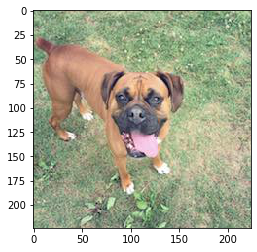

In [37]:
image = mx.image.imread(filename)
plt.imshow(image.asnumpy())

In [38]:
def transform(image):
    resized = mx.image.resize_short(image, 224) #minimum 224x224 images
    cropped, crop_info = mx.image.center_crop(resized, (224, 224))
    normalized = mx.image.color_normalize(cropped.astype(np.float32)/255,
                                      mean=mx.nd.array([0.485, 0.456, 0.406]),
                                      std=mx.nd.array([0.229, 0.224, 0.225]))
    # the network expect batches of the form (N,3,224,224)
    transposed = normalized.transpose((2,0,1))  # Transposing from (224, 224, 3) to (3, 224, 224)
    batchified = transposed.expand_dims(axis=0) # change the shape from (3, 224, 224) to (1, 3, 224, 224)
    return batchified

In [39]:
predictions = resnet18(transform(image)).softmax()
print(predictions.shape)

(1, 1000)


In [40]:
top_pred = predictions.topk(k=3)[0].asnumpy()

In [41]:
for index in top_pred:
    probability = predictions[0][int(index)]
    category = categories[int(index)]
    print("{}: {:.2f}%".format(category, probability.asscalar()*100))

boxer: 89.35%
bull mastiff: 6.38%
American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier: 1.98%


In [42]:
def predict(model, image, categories, k):
    predictions = model(transform(image)).softmax()
    top_pred = predictions.topk(k=k)[0].asnumpy()
    for index in top_pred:
        probability = predictions[0][int(index)]
        category = categories[int(index)]
        print("{}: {:.2f}%".format(category, probability.asscalar()*100))
    print('')

In [43]:
%%time
predict(densenet121, image, categories, 3)

boxer: 94.77%
bull mastiff: 2.26%
American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier: 1.69%

Wall time: 177 ms


In [44]:
%%time
predict(mobileNet, image, categories, 3)

boxer: 84.02%
bull mastiff: 13.63%
Rhodesian ridgeback: 0.66%

Wall time: 24.5 ms


In [45]:
%%time
predict(resnet18, image, categories, 3)

boxer: 89.35%
bull mastiff: 6.38%
American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier: 1.98%

Wall time: 34.9 ms


In [46]:
NUM_CLASSES = 10
with resnet18.name_scope():
    resnet18.output = gluon.nn.Dense(NUM_CLASSES)

In [47]:
print(resnet18.output)

Dense(None -> 10, linear)
